<center><h1> From small scale variability to mesoscale stability in surface ocean pH: implications for CO<sub>2</sub> equilibration </h1></center>
    
<center><h3> Code for analysis </h3></center>

**Louise Delaigue<sup>1</sup>, Gert-Jan Reichart<sup>1,2</sup>, Chris Galley<sup>3,4</sup>, Yasmina Ourradi<sup>1</sup> and Matthew P. Humphreys<sup>1</sup>**

<sup>1</sup>Department of Ocean Systems (OCS), NIOZ Royal Netherlands Institute for Sea Research, PO Box 59, 1790 AB Den Burg (Texel), the Netherlands

<sup>2</sup>Department of Earth Sciences, Utrecht University, Utrecht, the Netherlands

<sup>3</sup>Department of Earth Sciences, Memorial University of Newfoundland, St. John's, NL, A1B 3X5, Canada

<sup>4</sup>Department of Earth and Environmental Sciences, University of Ottawa, Ottawa, ON, K1N 6N5, Canada

### Abstract

One important aspect in understanding ocean acidification is the nature and drivers of pH variability in surface waters on smaller spatial (i.e., areas up to 100 km<sup>2</sup>) and temporal (i.e., days) scales, due to a lack of high-quality pH data at sufficiently high resolution. Here, we describe a simple, cost-effective optical system for continuous high-resolution surface seawater pH measurements. The system includes a PyroScience pH optode placed in a closed cell directly connected to the underway supply of the ship through which near-surface seawater is constantly pumped. Seawater pH is measured at a rate of 2 to 4 measurements min<sup>-1</sup> and is cross-calibrated using discrete carbonate system observations (total alkalinity, dissolved inorganic carbon and nutrients). This setup was tested during two cruises of various oceanographic conditions: the North Atlantic Ocean (December-January 2020) and the South Pacific Ocean (February-April 2022). 

Our findings reveal fine-scale fluctuations in surface seawater pH across the North Atlantic and South Pacific Oceans. While temperature is a significant abiotic factor driving these variations, it alone does not account for all observed changes. Instead, our results highlight the interplay between temperature, biological activity, and water masses effects on pH. Notably, the variability patterns differed between the two regions, suggesting regional differences in the dominant factors influencing pH. In the South Pacific, biological processes appeared to be mostly responsible for pH variability, while in the North Atlantic, additional abiotic and biotic factors complicated the correlation between expected and observed pH changes. 

Although surface seawater pH exhibited fine-scale variations, it remained relatively stable over a 24-hour cycle. This suggests that ocean systems have an inherent resilience to maintain pH equilibrium, ensuring a stable ocean-atmosphere CO<sub>2</sub> equilibrium despite short-term fluctuations. Thus, broader ocean-basin scale analyses may effectively capture the necessary variability for global CO<sub>2</sub> cycle assessments and their implications.


# 1 - Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

Import all libraries and functions that we need for the processing and analysis

In [2]:
# --- Standard Library ---
import os
import pathlib
from datetime import datetime, timedelta

# --- Data Manipulation and Analysis ---
import numpy as np
import pandas as pd
import xarray as xr

# --- Scientific Computing and Statistics ---
from scipy import fftpack, signal
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.optimize import fsolve
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.ticker as mticker
import seaborn as sns
import cmocean

# --- Geospatial Plotting ---
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Domain-Specific Scientific Libraries ---
import gsw
import PyCO2SYS as pyco2
import pyseaflux
from pyseaflux.fco2_pco2_conversion import pCO2_to_fCO2
import ephem
from haversine import haversine, Unit
import copernicusmarine as cm


# 2- Define working paths

## **Important** - Paths and Directories

| Name | Variable | Purpose |
| ---| --- | --- |
| Project | `PROJECT_PATH` | top level directory for the project |
| Processed Data | `DATA_PATH` | where the  data is stored |
| Figures | `FIG_PATH` | where we store any plotted figures during any part of the analysis|


# 3 - Apply SO279 - North Atlantic processing

In [3]:
# Load the SO279 dataset into a pandas DataFrame
full_path = "data/SO279/SO279_UWS_time_series_uncertainty.csv"

# Now, use the full_path to read your csv file
north_atlantic = pd.read_csv(full_path)

In [4]:
north_atlantic

,EXPOCODE,Cruise_ID,Year_UTC,Month_UTC,Day_UTC,Time_UTC,Latitude,Longitude,Depth,Temperature,TEMP_pH,Salinity,Salinity_flag,pH_TS_measured (optode),pH_TS_measured (optode) uncertainty,pH_flag
0,06SN20201204,SO279,2020,12,8,22:24:03,47.252500,-10.181389,3.0,13.4405,13.4405,35.754555,2,8.065519,0.003462,2
1,06SN20201204,SO279,2020,12,8,22:24:33,47.252500,-10.181389,3.0,13.4414,13.4414,35.755555,2,8.065133,0.003462,2
2,06SN20201204,SO279,2020,12,8,22:25:03,47.252222,-10.181389,3.0,13.4429,13.4429,35.755655,2,8.064723,0.003462,2
3,06SN20201204,SO279,2020,12,8,22:25:33,47.252222,-10.181111,3.0,13.4430,13.4430,35.755355,2,8.064481,0.003462,2
4,06SN20201204,SO279,2020,12,8,22:26:03,47.251944,-10.181389,3.0,13.4449,13.4449,35.755155,2,8.064401,0.003462,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43307,06SN20201204,SO279,2020,12,30,21:33:53,41.566111,-14.227222,3.0,14.7292,14.7292,35.907860,2,8.071260,0.003262,2
43308,06SN20201204,SO279,2020,12,30,21:34:23,41.584167,-14.207778,3.0,14.7245,14.7245,35.908560,2,8.069692,0.003266,2
43309,06SN20201204,SO279,2020,12,30,21:34:53,41.601944,-14.188611,3.0,14.7290,14.7290,35.907360,2,8.073571,0.003272,2
43310,06SN20201204,SO279,2020,12,30,21:35:23,41.619167,-14.169722,3.0,14.7092,14.7092,35.910460,2,8.070207,0.003278,2


### Low level processing

In [5]:
# Remove the first row, which contains units
north_atlantic = north_atlantic.drop(north_atlantic.index[0])

# Get a list of column names from the DataFrame
headers = list(north_atlantic.columns)

# Filter out any rows where the "pH_flag" column is not equal to 2
north_atlantic["pH_flag"] = north_atlantic["pH_flag"].astype(int)
L = north_atlantic["pH_flag"] == 2
north_atlantic = north_atlantic[L]

# Combine the year, month, day, and time columns into a single datetime column
north_atlantic["datetime"] = (
    north_atlantic["Year_UTC"].astype(str)
    + "-"
    + north_atlantic["Month_UTC"].astype(str)
    + "-"
    + north_atlantic["Day_UTC"].astype(str)
    + " "
    + north_atlantic["Time_UTC"].astype(str)
)

# Convert the "datetime" column to datetime objects
north_atlantic["datetime"] = pd.to_datetime(north_atlantic["datetime"])

# Convert datetime objects to numeric timestamps
north_atlantic["datenum"] = north_atlantic["datetime"].apply(lambda x: x.timestamp())

### Biogeochemical processing 

In [6]:
# Convert several columns to numeric data types
north_atlantic["Latitude"] = pd.to_numeric(north_atlantic["Latitude"])
north_atlantic["Longitude"] = pd.to_numeric(north_atlantic["Longitude"])
north_atlantic["Depth"] = pd.to_numeric(north_atlantic["Depth"])
north_atlantic["Temperature"] = pd.to_numeric(north_atlantic["Temperature"])
north_atlantic["Salinity"] = pd.to_numeric(north_atlantic["Salinity"])
north_atlantic["pH_TS_measured (optode)"] = pd.to_numeric(north_atlantic["pH_TS_measured (optode)"])

In [7]:
def calculate_alkalinity(df, temp_col, sal_col):
    """
    Calculate total alkalinity (TA) for the North Atlantic using the empirical equation from Lee et al. (2006).

    Parameters:
    df (DataFrame): DataFrame containing temperature and salinity data.
    temp_col (str): Column name for sea surface temperature (SST).
    sal_col (str): Column name for sea surface salinity (SSS).

    Returns:
    Series: A pandas Series containing calculated TA values.
    """
    ta = (
        2305 +
        53.97 * (df[sal_col] - 35) +
        2.74 * (df[sal_col] - 35)**2 -
        1.16 * (df[temp_col] - 20) -
        0.040 * (df[temp_col] - 20)**2
    )

    return ta


In [8]:
# Estimate alkalinity from Lee et al (2006)
north_atlantic["talk"] = calculate_alkalinity(north_atlantic, 'Temperature', 'Salinity')

# Estimate other CO2 variables
uncertainty_from = pyco2.uncertainty_OEDG18.copy()
uncertainty_from["par1"] = 5.5 # from uncertainty back in SA chapter RMSE for TA estimation
uncertainty_from["par2"] = north_atlantic['pH_TS_measured (optode) uncertainty'].to_numpy()

co2_system = pyco2.sys(
    par1=north_atlantic["talk"].to_numpy(),
    par2=north_atlantic["pH_TS_measured (optode)"].to_numpy(),
    par1_type=1,
    par2_type=3,
    salinity=north_atlantic["Salinity"].to_numpy(),
    temperature=north_atlantic["Temperature"].to_numpy(),
    pressure=3,
    uncertainty_from=uncertainty_from,
    uncertainty_into=["dic", "fCO2"]
)

# Assign variables back to df
north_atlantic["tco2"] = co2_system["dic"]
north_atlantic["tco2_unc"] = co2_system["u_dic"]
north_atlantic["fco2"] = co2_system["fCO2"]
north_atlantic["fco2_unc"] = co2_system["u_fCO2"]

### Underway metadata matchup

In [9]:
# Import underway SMB dataset
chunky = pd.read_csv('data/SO279/smb_all_hr.dat',
                 chunksize=150000,
                 na_values=9999,
                 delimiter='\t',
                 encoding= 'unicode_escape',
                 low_memory=False)

# create empty list to hold cleaned up chunks
smb_list = []

# rename temp_source column to python friendly, then only keep where 
# temp_source has data, then store cleaned up chunks into smb_list
for file in chunky:
    file = file.drop([file.index[0], file.index[1]])
    file.reset_index(drop=True)
    rn = {
       'SMB.RSSMB.T_SBE38':'SBE38_water_temp'
       }
    file.rename(rn, axis=1, inplace=True)
    smb_list.append(file)

# create 1 df holding all cleaned up smb data
smb = pd.concat(smb_list)

In [10]:
# Rename headers with python friendly north_atlanticmes
rn = {
      'date time':'datetime',
      'Weatherstation.PDWDC.Airtemperature':'WS_airtemp',
      'Weatherstation.PDWDC.Barometric':'WS_baro',
      'Weatherstation.PDWDC.Course':'WS_course',
      'Weatherstation.PDWDC.Date':'WS_date',
      'Weatherstation.PDWDC.Heading':'WS_heading',
      'Weatherstation.PDWDC.Humidity':'WS_humidity',
      'Weatherstation.PDWDC.Latitude':'WS_lat',
      'Weatherstation.PDWDC.Longitude':'WS_lon',
      'Weatherstation.PDWDC.Longwave':'WS_longwave',
      'Weatherstation.PDWDC.NormalizedTo':'WS_normto',
      'Weatherstation.PDWDC.Pyrogeometer':'WS_pyrogeometer',
      'Weatherstation.PDWDC.SensorValue':'WS_sensorvalue',
      'Weatherstation.PDWDC.Sentence':'WS_sentence',
      'Weatherstation.PDWDC.Shortwave':'WS_shortwave',
      'Weatherstation.PDWDC.Speed':'WS_speed',
      'Weatherstation.PDWDC.Timestamp':'WS_timestamp',
      'Weatherstation.PDWDC.Watertemperature':'WS_watertemp',
      'Weatherstation.PDWDC.Winddirection_rel':'WS_winddirection_rel',
      'Weatherstation.PDWDC.Winddirection_true':'WS_winddirection_true',
      'Weatherstation.PDWDC.Windspeed_rel':'WS_windspeed_rel',
      'Weatherstation.PDWDC.Windspeed_true':'wind_speed',
      'Weatherstation.PDWDC.Windspeed_true_Bft':'WS_windspeed_true_bft',
      'SMB.RSSMB.Chl':'smb_chl',
      'SMB.RSSMB.C_SBE45':'SBE_45_C',
      'SMB.RSSMB.Date':'date',
      'SMB.RSSMB.Delay':'delay',
      'SMB.RSSMB.Depth':'depth',
      'SMB.RSSMB.EW':'ew',
      'SMB.RSSMB.Flow':'flow',
      'SMB.RSSMB.Latitude':'lat',
      'SMB.RSSMB.Longitude':'lon',
      'SMB.RSSMB.north_atlanticme':'smb_north_atlanticme',
      'SMB.RSSMB.NS':'ns',
      'SMB.RSSMB.RVK':'system',
      'SMB.RSSMB.Sal_SBE45':'SBE45_sal',
      'SMB.RSSMB.Sentence':'sentence',
      'SMB.RSSMB.SN':'sn',
      'SMB.RSSMB.SV_SBE45':'SBE45_sv',
      'SMB.RSSMB.SV_insito':'insitu_sv',
      'SMB.RSSMB.Status':'smb_status',
      'SMB.RSSMB.SV_AML':'smb_sv_aml',
      'SMB.RSSMB.T_SBE45':'SBE45_water_temp',
      'SMB.RSSMB.Time':'smb_time',
      'SMB.RSSMB.Tur':'smb_tur',
#       'Weatherstation.PEUMA.Air_pressure':'air_pressure_hpa',
#       'Weatherstation.PEUMA.Absolute_wind_speed':'wind_speed',
      }

smb.rename(rn, axis=1, inplace=True)

In [11]:
# Convert 'datetime' column to pandas datetime object
smb['datetime'] = pd.to_datetime(smb['datetime'], format='mixed')

# Format 'datetime' column to the desired format
smb['datetime'] = smb['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [12]:
# Merge 'chl' and 'wind_speed' from 'smb' to 'north_atlantic' based on 'datetime'
north_atlantic["datetime"] = pd.to_datetime(north_atlantic["datetime"])
smb["datetime"] = pd.to_datetime(smb["datetime"])
north_atlantic = pd.merge(north_atlantic, smb[['datetime', 'smb_chl', 'wind_speed', 'smb_tur']], on='datetime', how='left')

In [13]:
# Grab the rate from the SMB
print(smb.flow.mean())
print(smb.flow.min())
print(smb.flow.max())

6.045650170076126
0.02
10.1


In [14]:
# Drop the redundant 'date' column from the finorth_atlanticl merged DataFrame
north_atlantic.drop(columns='datetime', inplace=True)

# List column headers
headers = list(north_atlantic.columns)

# Only keep good data
north_atlantic["pH_flag"] = north_atlantic["pH_flag"].astype(int)
L = north_atlantic["pH_flag"] == 2
north_atlantic = north_atlantic[L]

# First, combine the four columns into a single column
north_atlantic["datetime"] = (
    north_atlantic["Year_UTC"].astype(str)
    + "-"
    + north_atlantic["Month_UTC"].astype(str)
    + "-"
    + north_atlantic["Day_UTC"].astype(str)
    + " "
    + north_atlantic["Time_UTC"].astype(str)
)
north_atlantic["datetime"] = pd.to_datetime(
    north_atlantic["datetime"]
)  # Convert "datetime" to datetime objects
north_atlantic["datenum"] = north_atlantic["datetime"].apply(
    lambda x: x.timestamp()
)  # Convert "datetime" to numeric timestamp

# Ensure rest of columns are numeric
north_atlantic["Latitude"] = pd.to_numeric(north_atlantic["Latitude"])
north_atlantic["Longitude"] = pd.to_numeric(north_atlantic["Longitude"])
north_atlantic["Depth"] = pd.to_numeric(north_atlantic["Depth"])
north_atlantic["Temperature"] = pd.to_numeric(north_atlantic["Temperature"])
north_atlantic["pH_TS_measured (optode)"] = pd.to_numeric(north_atlantic["pH_TS_measured (optode)"])
north_atlantic["smb_chl"] = pd.to_numeric(north_atlantic["smb_chl"])
north_atlantic["wind_speed"] = pd.to_numeric(north_atlantic["wind_speed"])

# Only keep rows with Chl
L = north_atlantic["smb_chl"].notnull()
north_atlantic = north_atlantic[L]

## Apply Chl-a correction

In [15]:
# Create a boolean mask to identify values outside the range [0, 1]
mask = (north_atlantic['smb_chl'] < 0) | (north_atlantic['smb_chl'] > 1)

# Replace values outside the range with NaN
north_atlantic.loc[mask, 'smb_chl'] = np.nan

# Find indices of NaN values
nan_indices = north_atlantic.index[north_atlantic['smb_chl'].isna()]

# Iterate over indices with NaN values
for idx in nan_indices:
    # Check if there are values before and after NaN
    if idx > 0 and idx < len(nan_indices) - 1:
        # Calculate mean of neighboring values
        mean_value = (north_atlantic.at[idx - 1, 'smb_chl'] + north_atlantic.at[idx + 1, 'smb_chl']) / 2
        # Replace NaN with mean value
        north_atlantic.at[idx, 'smb_chl'] = mean_value

In [16]:
chl = list(north_atlantic.smb_chl)
chl

[0.584,
 0.606,
 0.577,
 0.577,
 0.584,
 0.577,
 0.584,
 0.599,
 0.584,
 0.577,
 0.584,
 0.599,
 0.577,
 0.573,
 0.569,
 0.606,
 0.599,
 0.584,
 0.591,
 0.599,
 0.591,
 0.591,
 0.591,
 0.584,
 0.591,
 0.584,
 0.591,
 0.584,
 0.591,
 0.606,
 0.591,
 0.599,
 0.606,
 0.591,
 0.621,
 0.613,
 0.606,
 0.613,
 0.606,
 0.606,
 0.599,
 0.621,
 0.6134999999999999,
 0.606,
 0.591,
 0.613,
 0.621,
 0.621,
 0.606,
 0.606,
 0.591,
 0.628,
 0.591,
 0.606,
 0.599,
 0.591,
 0.584,
 0.599,
 0.599,
 0.599,
 0.606,
 0.599,
 0.613,
 0.599,
 0.599,
 0.621,
 0.599,
 0.591,
 0.606,
 0.606,
 0.606,
 0.606,
 0.599,
 0.621,
 0.599,
 0.613,
 0.613,
 0.599,
 0.599,
 0.606,
 0.606,
 0.606,
 0.606,
 0.613,
 0.606,
 0.599,
 0.606,
 0.584,
 0.613,
 0.613,
 0.591,
 0.606,
 0.621,
 0.584,
 0.606,
 0.628,
 0.591,
 0.584,
 0.613,
 0.606,
 0.606,
 0.584,
 0.577,
 0.584,
 0.5805,
 0.577,
 0.591,
 0.591,
 0.577,
 0.591,
 0.562,
 0.562,
 0.584,
 0.577,
 0.584,
 0.584,
 0.555,
 0.562,
 0.569,
 0.569,
 0.569,
 0.562,
 0.562,
 0

In [17]:
# Save processed SO279 dataset into a pandas DataFrame
filename = "data/SO279/SO279_processed.csv"
north_atlantic.to_csv(filename, index=False)

# 4 - Apply SO289 - South Pacific processing

In [18]:
# Load the SO279 dataset into a pandas DataFrame
filename = "data/SO289/SO289_UWS_time_series_V2_uncertainty.csv"

# Now, use the full_path to read csv file
south_pacific = pd.read_csv(filename, skiprows=15)

# Remove the first row, which contains units
south_pacific = south_pacific.drop(south_pacific.index[0]).reset_index(drop=True)

In [19]:
south_pacific

,EXPOCODE,Cruise_ID,Year_UTC,Month_UTC,Day_UTC,Time_UTC,Latitude,Longitude,Depth,Temperature,TEMP_pH,Salinity,pH_TS_measured (optode),pH_TS_measured (optode) uncertainty,pH_flag
0,06S220220218,SO289,2022,2,28,16:20:13,-32.684444444444445,-81.99972222222222,3,19.8909,19.8909,34.4224,8.025005936701563,8.732926438649894e-07,2
1,06S220220218,SO289,2022,2,28,16:20:28,-32.68333333333334,-82.00722222222223,3,19.8916,19.8916,34.4227,8.024951862809475,1.8809381696125432e-06,2
2,06S220220218,SO289,2022,2,28,16:20:43,-32.68222222222222,-82.015,3,19.8912,19.8912,34.4219,8.024944156171786,2.888583681267652e-06,2
3,06S220220218,SO289,2022,2,28,16:20:58,-32.68138888888889,-82.02166666666666,3,19.8914,19.8914,34.4225,8.025031947057462,3.896228974991837e-06,2
4,06S220220218,SO289,2022,2,28,16:21:13,-32.68055555555556,-82.02888888888889,3,19.8927,19.8927,34.4227,8.024983787884455,4.903873846146861e-06,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78029,06S220220218,SO289,2022,3,31,21:28:59,-25.740833,-178.948056,3,25.6646,25.6646,35.4875,8.018073,0.000011,2
78030,06S220220218,SO289,2022,3,31,21:29:14,-25.740833,-178.948056,3,25.6639,25.6639,35.4872,8.017081,0.000008,2
78031,06S220220218,SO289,2022,3,31,21:29:29,-25.740833,-178.948056,3,25.6661,25.6661,35.4872,8.017991,0.000005,2
78032,06S220220218,SO289,2022,3,31,21:29:44,-25.740833,-178.948056,3,25.671,25.671,35.4877,8.018007,0.000003,2


### Low level processing

In [20]:
# Remove the first row, which contains units
south_pacific = south_pacific.drop(south_pacific.index[0]).reset_index(drop=True)

# Get a list of column names from the DataFrame
headers = list(south_pacific.columns)

# Filter out any rows where the "pH_flag" column is not equal to 2
south_pacific["pH_flag"] = south_pacific["pH_flag"].astype(int)
L = south_pacific["pH_flag"] == 2
south_pacific = south_pacific[L]

# Combine the year, month, day, and time columns into a single datetime column
south_pacific["datetime"] = (
    south_pacific["Year_UTC"].astype(str)
    + "-"
    + south_pacific["Month_UTC"].astype(str)
    + "-"
    + south_pacific["Day_UTC"].astype(str)
    + " "
    + south_pacific["Time_UTC"].astype(str)
)

# Convert the "datetime" column to datetime objects
south_pacific["datetime"] = pd.to_datetime(south_pacific["datetime"])

# Convert datetime objects to numeric timestamps
south_pacific["datenum"] = south_pacific["datetime"].apply(lambda x: x.timestamp())

### Biogeochemical processing

In [21]:
# Convert several columns to numeric data types
south_pacific["Latitude"] = pd.to_numeric(south_pacific["Latitude"])
south_pacific["Longitude"] = pd.to_numeric(south_pacific["Longitude"])
south_pacific["Depth"] = pd.to_numeric(south_pacific["Depth"])
south_pacific["Temperature"] = pd.to_numeric(south_pacific["Temperature"])
south_pacific["Salinity"] = pd.to_numeric(south_pacific["Salinity"])
south_pacific["pH_TS_measured (optode)"] = pd.to_numeric(south_pacific["pH_TS_measured (optode)"])
south_pacific["pH_TS_measured (optode) uncertainty"] = pd.to_numeric(south_pacific["pH_TS_measured (optode) uncertainty"])

In [22]:
def calculate_alkalinity(df, temp_col, sal_col):
    """
    Calculate total alkalinity (TA) for the South Pacific (Subtropics) using the empirical equation from Lee et al. (2006).

    Parameters:
    df (DataFrame): DataFrame containing temperature and salinity data.
    temp_col (str): Column name for sea surface temperature (SST).
    sal_col (str): Column name for sea surface salinity (SSS).

    Returns:
    Series: A pandas Series containing calculated TA values.
    """
    ta = (
        2305 +
        58.66 * (df[sal_col] - 35) +
        2.32 * (df[sal_col] - 35)**2 -
        1.41 * (df[temp_col] - 20) +
        0.040 * (df[temp_col] - 20)**2
    )

    return ta


In [23]:
# Estimate alkalinity from Lee et al (2006)
south_pacific["talk"] = calculate_alkalinity(south_pacific, 'Temperature', 'Salinity')

# Estimate other CO2 variables
uncertainty_from = pyco2.uncertainty_OEDG18.copy()
uncertainty_from["par1"] = 5.5 # from RMSE of NUTS in SO289_processing
uncertainty_from["par2"] = south_pacific['pH_TS_measured (optode) uncertainty'].to_numpy()

co2_system = pyco2.sys(
    par1=south_pacific["talk"].to_numpy(),
    par2=south_pacific["pH_TS_measured (optode)"].to_numpy(),
    par1_type=1,
    par2_type=3,
    salinity=south_pacific["Salinity"].to_numpy(),
    temperature=south_pacific["Temperature"].to_numpy(),
    pressure=3,
    uncertainty_from=uncertainty_from,
    uncertainty_into=["dic", "fCO2"]
)

# Assign variables back to df
south_pacific["tco2"] = co2_system["dic"]
south_pacific["tco2_unc"] = co2_system["u_dic"]
south_pacific["fco2"] = co2_system["fCO2"]
south_pacific["fco2_unc"] = co2_system["u_fCO2"]

### Underway metadata matchup

In [24]:
# Import SMB underway data
smb = pd.read_csv('data/SO289/SO289_underway_data_SMB_simple.dat',
                 # chunksize=150000,
                 na_values=9,
                 skiprows=[1, 2],
                 delimiter='\t',
                 encoding= 'unicode_escape',
                 low_memory=False)

In [25]:
# Rename headers with python friendly names
rn = {
      'date time':'datetime',
      'Weatherstation.PDWDC.Airtemperature':'WS_airtemp',
      'Weatherstation.PDWDC.Barometric':'WS_baro',
      'Weatherstation.PDWDC.Course':'WS_course',
      'Weatherstation.PDWDC.Date':'WS_date',
      'Weatherstation.PDWDC.Heading':'WS_heading',
      'Weatherstation.PDWDC.Humidity':'WS_humidity',
      'Weatherstation.PDWDC.Latitude':'WS_lat',
      'Weatherstation.PDWDC.Longitude':'WS_lon',
      'Weatherstation.PDWDC.Longwave':'WS_longwave',
      'Weatherstation.PDWDC.NormalizedTo':'WS_normto',
      'Weatherstation.PDWDC.Pyrogeometer':'WS_pyrogeometer',
      'Weatherstation.PDWDC.SensorValue':'WS_sensorvalue',
      'Weatherstation.PDWDC.Sentence':'WS_sentence',
      'Weatherstation.PDWDC.Shortwave':'WS_shortwave',
      'Weatherstation.PDWDC.Speed':'WS_speed',
      'Weatherstation.PDWDC.Timestamp':'WS_timestamp',
      'Weatherstation.PDWDC.Watertemperature':'WS_watertemp',
      'Weatherstation.PDWDC.Winddirection_rel':'WS_winddirection_rel',
      'Weatherstation.PDWDC.Winddirection_true':'WS_winddirection_true',
      'Weatherstation.PDWDC.Windspeed_rel':'WS_windspeed_rel',
      'Weatherstation.PDWDC.Windspeed_true':'wind_speed',
      'Weatherstation.PDWDC.Windspeed_true_Bft':'WS_windspeed_true_bft',
      'Weatherstation.PEUMA.Absolute_wind_speed':'wind_speed',
      'SMB.RSSMB.Chl':'smb_chl',
      'SMB.RSSMB.C_SBE45':'SBE_45_C',
      'SMB.RSSMB.Date':'date',
      'SMB.RSSMB.Delay':'delay',
      'SMB.RSSMB.Depth':'depth',
      'SMB.RSSMB.EW':'ew',
      'SMB.RSSMB.Flow':'flow',
      'SMB.RSSMB.Latitude':'lat',
      'SMB.RSSMB.Longitude':'lon',
      'SMB.RSSMB.Name':'smb_name',
      'SMB.RSSMB.NS':'ns',
      'SMB.RSSMB.RVK':'system',
      'SMB.RSSMB.Sal_SBE45':'SBE45_sal',
      'SMB.RSSMB.Sentence':'sentence',
      'SMB.RSSMB.SN':'sn',
      'SMB.RSSMB.SV_SBE45':'SBE45_sv',
      'SMB.RSSMB.SV_insito':'insitu_sv',
      'SMB.RSSMB.Status':'smb_status',
      'SMB.RSSMB.SV_AML':'smb_sv_aml',
      'SMB.RSSMB.T_SBE45':'SBE45_water_temp',
      'SMB.RSSMB.Time':'smb_time',
      'SMB.RSSMB.Tur':'smb_tur',
      'SMB.RSSMB.Delay':'delay',
      'SMB.RSSMB.Date':'date',
      'SMB.RSSMB.Latitude':'lat',
      'SMB.RSSMB.Longitude':'lon',
      'SMB.RSSMB.Sal_SBE45':'SBE45_sal',
      'SMB.RSSMB.T_SBE38':'SBE38_temp',
      'Weatherstation.PEUMA.Air_pressure':'air_pressure_hpa'
      }

smb.rename(rn, axis=1, inplace=True)

In [26]:
# Grab the rate from the SMB
print(smb.flow.mean())
print(smb.flow.min())
print(smb.flow.max())

8.736491831183182
0.02
14.77


In [27]:
# Convert 'datetime' column to pandas datetime object
smb['datetime'] = pd.to_datetime(smb['datetime'], format='%Y/%m/%d %H:%M:%S')

# Format 'datetime' column to the desired format
smb['datetime'] = smb['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [28]:
# Merge 'chl' from 'smb' to 'na' based on 'datetime'
south_pacific["datetime"] = pd.to_datetime(south_pacific["datetime"])
smb["datetime"] = pd.to_datetime(smb["datetime"])
south_pacific = pd.merge(south_pacific, smb[['datetime', 'smb_chl', 'wind_speed', 'smb_tur', 'air_pressure_hpa']], on='datetime', how='left')

In [29]:
# List column headers
headers = list(south_pacific.columns)

# Only keep good data
south_pacific["pH_flag"] = south_pacific["pH_flag"].astype(int)
L = south_pacific["pH_flag"] == 2
south_pacific = south_pacific[L]

# First, combine the four columns into a single column
south_pacific["datetime"] = (
    south_pacific["Year_UTC"].astype(str)
    + "-"
    + south_pacific["Month_UTC"].astype(str)
    + "-"
    + south_pacific["Day_UTC"].astype(str)
    + " "
    + south_pacific["Time_UTC"].astype(str)
)
south_pacific["datetime"] = pd.to_datetime(
    south_pacific["datetime"]
)  # Convert "datetime" to datetime objects
south_pacific["datenum"] = south_pacific["datetime"].apply(
    lambda x: x.timestamp()
)  # Convert "datetime" to numeric timestamp

# Ensure rest of columns are numeric
south_pacific["Latitude"] = pd.to_numeric(south_pacific["Latitude"])
south_pacific["Longitude"] = pd.to_numeric(south_pacific["Longitude"])
south_pacific["Depth"] = pd.to_numeric(south_pacific["Depth"])
south_pacific["Temperature"] = pd.to_numeric(south_pacific["Temperature"])
south_pacific["pH_TS_measured (optode)"] = pd.to_numeric(south_pacific["pH_TS_measured (optode)"])
south_pacific["wind_speed"] = pd.to_numeric(south_pacific["wind_speed"])

# Only keep rows with Chl
L = south_pacific["smb_chl"].notnull()
south_pacific = south_pacific[L]

In [30]:
# Save to csv
filename = "data/SO289/SO289_processed.csv"
south_pacific.to_csv(filename, index=False)

In [31]:
south_pacific.columns

Index(['EXPOCODE', 'Cruise_ID', 'Year_UTC', 'Month_UTC', 'Day_UTC', 'Time_UTC',
       'Latitude', 'Longitude', 'Depth', 'Temperature', 'TEMP_pH', 'Salinity',
       'pH_TS_measured (optode)', 'pH_TS_measured (optode) uncertainty',
       'pH_flag', 'datetime', 'datenum', 'talk', 'tco2', 'tco2_unc', 'fco2',
       'fco2_unc', 'smb_chl', 'wind_speed', 'smb_tur', 'air_pressure_hpa'],
      dtype='object')

# 5 - Convert UTC to Local Solar Time (LST)

In [32]:
# Convert the "datetime" column to datetime objects
north_atlantic["datetime"] = pd.to_datetime(north_atlantic["datetime"])
south_pacific["datetime"] = pd.to_datetime(south_pacific["datetime"])

In [33]:
# Function to convert UTC to local solar time
def convert_to_lst(df):
    df["Longitude_mean"] = df.groupby(df.datetime.dt.date)["Longitude"].transform("mean")
    df["time_offset"] = (df["Longitude_mean"] / 15).astype(int)
    df["datetime_lst"] = df["datetime"] + df["time_offset"].apply(lambda x: timedelta(hours=x))
    return df

In [34]:
# Convert UTC to local solar time for both datasets
north_atlantic = convert_to_lst(north_atlantic)
south_pacific = convert_to_lst(south_pacific)

In [35]:
south_pacific

,EXPOCODE,Cruise_ID,Year_UTC,Month_UTC,Day_UTC,Time_UTC,Latitude,Longitude,Depth,Temperature,...,tco2_unc,fco2,fco2_unc,smb_chl,wind_speed,smb_tur,air_pressure_hpa,Longitude_mean,time_offset,datetime_lst
0,06S220220218,SO289,2022,2,28,16:20:28,-32.683333,-82.007222,3,19.8916,...,7.474833,419.046762,7.910484,0.124,9.4,0.282,1026.0,-82.239567,-5,2022-02-28 11:20:28
1,06S220220218,SO289,2022,2,28,16:20:43,-32.682222,-82.015000,3,19.8912,...,7.474639,419.049905,7.910517,0.124,9.2,0.286,1025.9,-82.239567,-5,2022-02-28 11:20:43
2,06S220220218,SO289,2022,2,28,16:20:58,-32.681389,-82.021667,3,19.8914,...,7.475205,418.953607,7.908826,0.124,10.6,0.286,1026.1,-82.239567,-5,2022-02-28 11:20:58
3,06S220220218,SO289,2022,2,28,16:21:13,-32.680556,-82.028889,3,19.8927,...,7.475090,419.009648,7.909851,0.117,10.0,0.288,1025.8,-82.239567,-5,2022-02-28 11:21:13
4,06S220220218,SO289,2022,2,28,16:21:28,-32.679444,-82.035833,3,19.8914,...,7.480912,417.680488,7.886251,0.131,10.1,0.290,1026.1,-82.239567,-5,2022-02-28 11:21:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78028,06S220220218,SO289,2022,3,31,21:28:59,-25.740833,-178.948056,3,25.6646,...,8.119668,430.720281,8.280230,0.044,4.3,0.211,1012.4,-177.695622,-11,2022-03-31 10:28:59
78029,06S220220218,SO289,2022,3,31,21:29:14,-25.740833,-178.948056,3,25.6639,...,8.113591,431.923615,8.301503,0.036,4.4,0.214,1012.4,-177.695622,-11,2022-03-31 10:29:14
78030,06S220220218,SO289,2022,3,31,21:29:29,-25.740833,-178.948056,3,25.6661,...,8.119258,430.814911,8.281931,0.036,3.2,0.218,1012.5,-177.695622,-11,2022-03-31 10:29:29
78031,06S220220218,SO289,2022,3,31,21:29:44,-25.740833,-178.948056,3,25.6710,...,8.119894,430.794902,8.281723,0.044,3.3,0.216,1012.5,-177.695622,-11,2022-03-31 10:29:44


# 6 - Plot geographic distribution for both cruises

In [36]:
ocean_soda = xr.open_dataset("data/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc", engine='netcdf4')

In [37]:
ph_total_last_time = ocean_soda['ph_total'].isel(time=-1)

In [38]:
ph_total_last_time

<xarray.DataArray 'ph_total' (lat: 180, lon: 360)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2022-12-15
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    units:        -log([H+])
    description:  surface ocean pH on the total scale

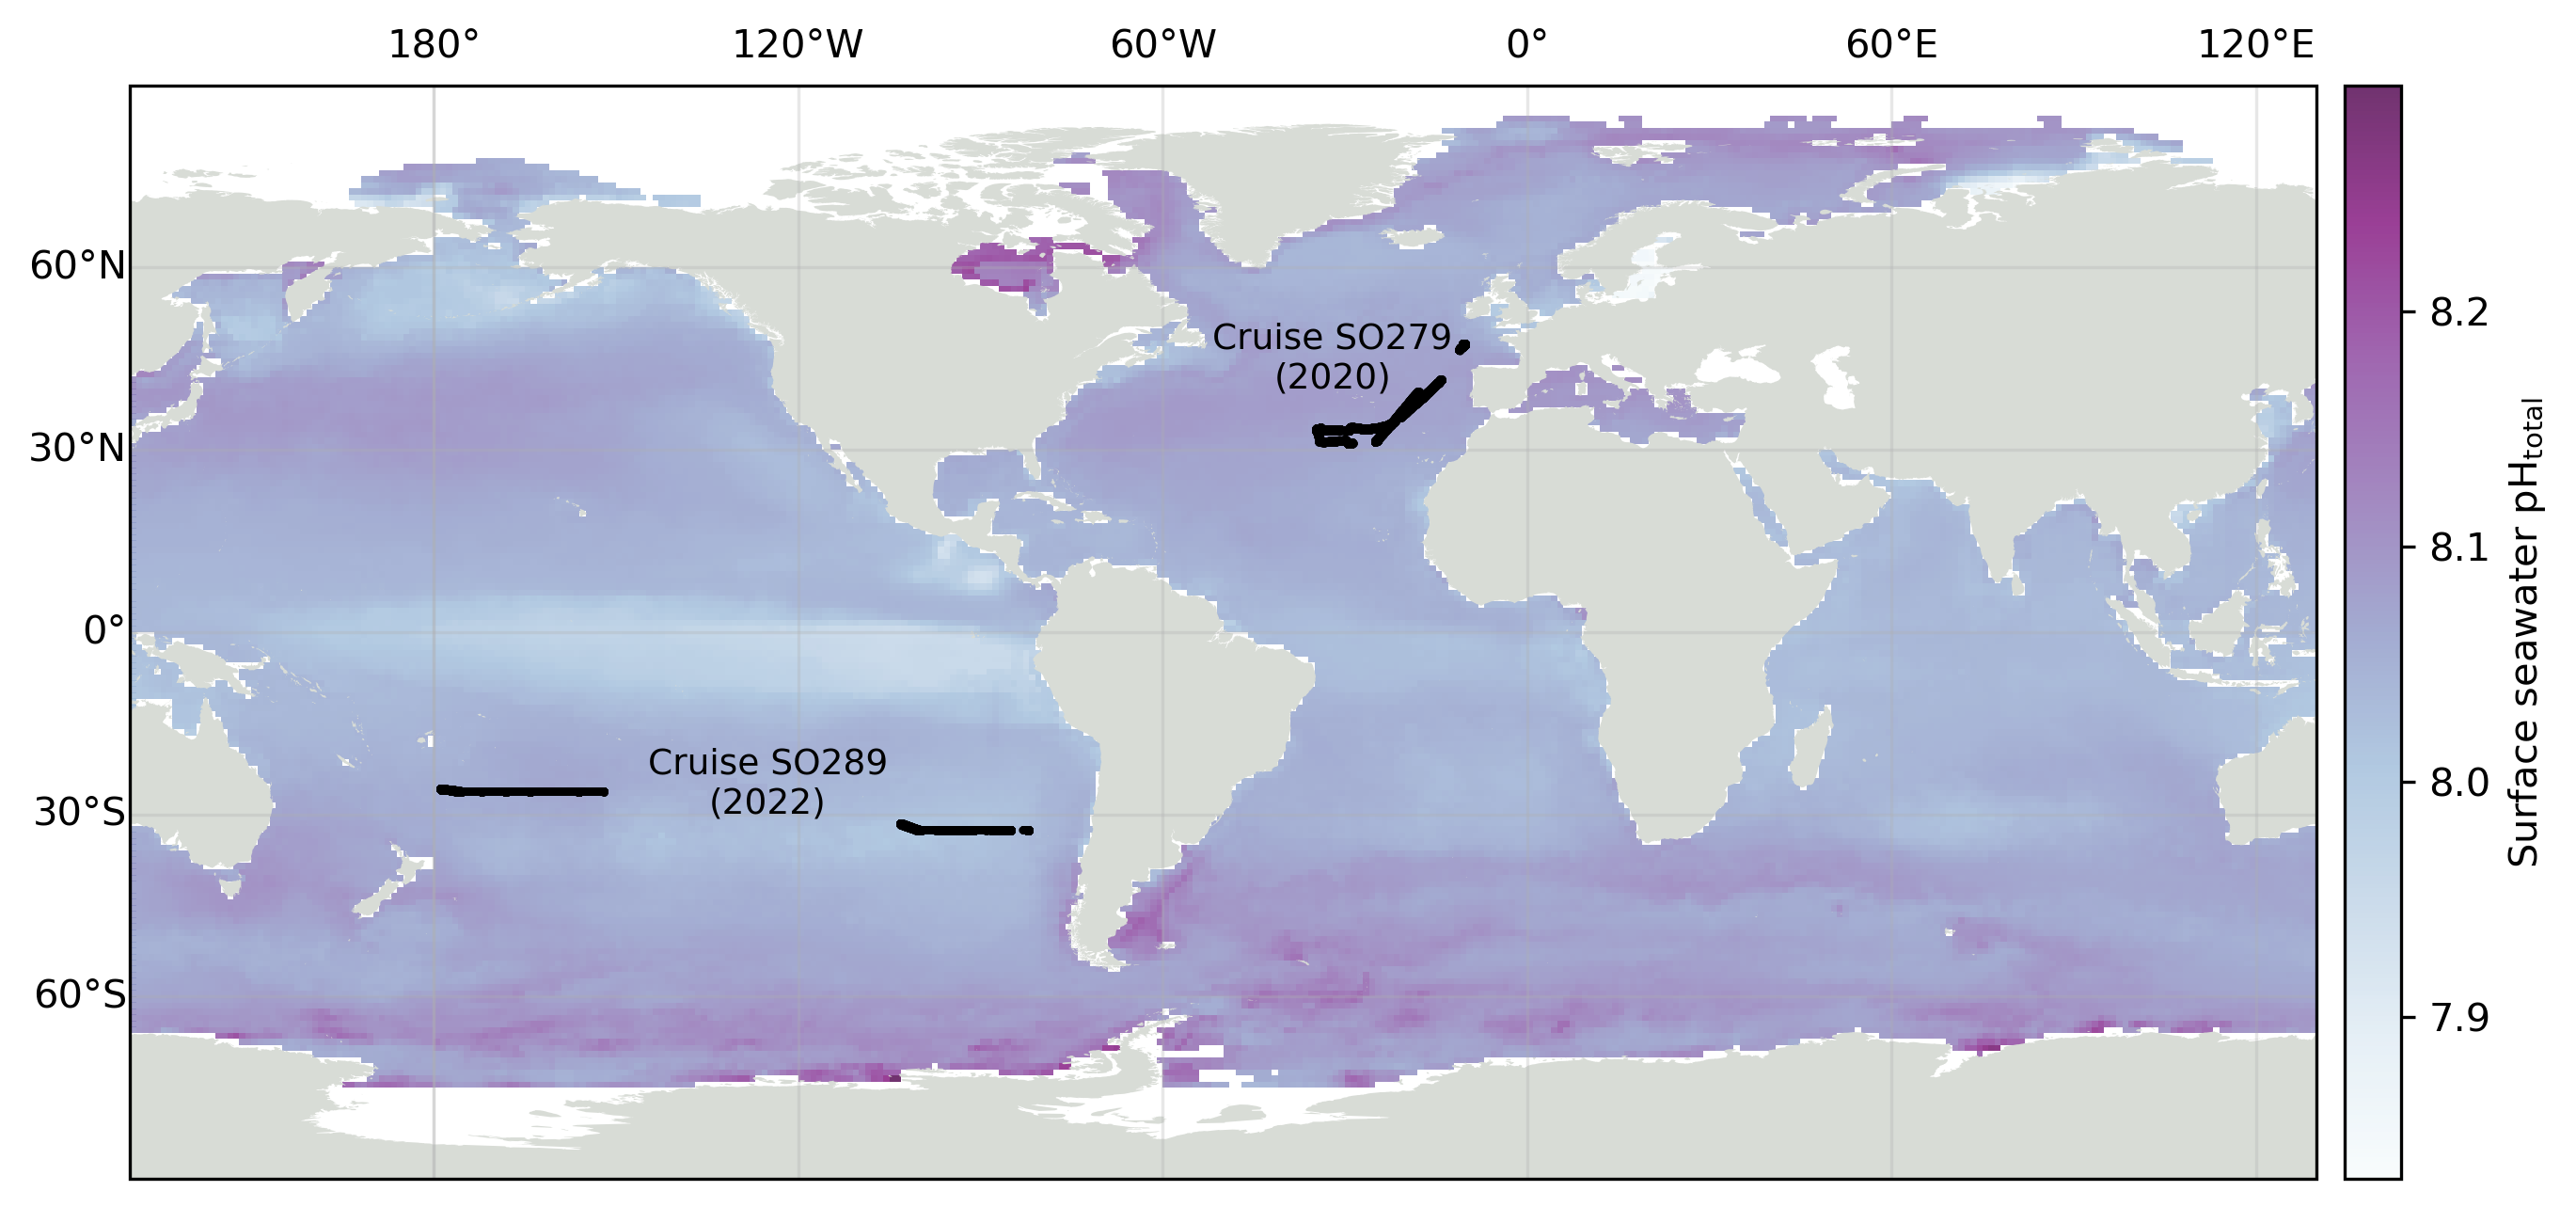

In [39]:
# Load OCEAN-SOCA pH data
ocean_soda = ocean_soda['ph_total'].isel(time=-1)

# Sample trajectory data
north_atlantic_lons = north_atlantic.Longitude
north_atlantic_lats = north_atlantic.Latitude

south_pacific_lons = south_pacific.Longitude
south_pacific_lats = south_pacific.Latitude

trajectory_c = 'xkcd:black'

# Create the figure and axis with a map projection
fig = plt.figure(dpi=300, figsize=(10, 8))
ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=-50))

# Plotting the trajectories
ax.scatter(north_atlantic_lons, north_atlantic_lats, color=trajectory_c, s=1, label='SO279 - December 2020', transform=ccrs.PlateCarree())
ax.scatter(south_pacific_lons, south_pacific_lats, color=trajectory_c, s=1, label='SO289 - February/March/April 2022', transform=ccrs.PlateCarree())

# Add pH
cmap = 'BuPu'

bathymetry = (
    ocean_soda
    .plot(
        add_colorbar=False,
        ax=ax,
        cmap=cmap,
        alpha=0.8,
        transform=ccrs.PlateCarree(),
        zorder=0
    )
)

cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
cbar = plt.colorbar(bathymetry, cax=cax, fraction=1)
cbar.set_label(r'Surface seawater pH$_{\mathrm{total}}$')

#  land areas
ax.add_feature(
    cfeature.NaturalEarthFeature(
        "physical", "land", "10m"
    ),
    facecolor="xkcd:light grey", # xkcd:dark grey
    edgecolor="none",
)

# Set the extent
ax.set_global()

# Add annotations
ax.text(-32, 45,'Cruise SO279\n(2020)', transform=ccrs.PlateCarree(), color=trajectory_c, fontsize=9, ha='center', va='center')
ax.text(-125, -25,'Cruise SO289\n(2022)', transform=ccrs.PlateCarree(), color=trajectory_c, fontsize=9, ha='center', va='center')

# Add gridlines, legend, and title
gl = ax.gridlines(alpha=0.3, draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False

ax.set_title("")

plt.savefig("figs/figure1.png", dpi=300, bbox_inches = 'tight', pad_inches=0.1)

# 7 - Mean diurnal cycles

The below function only keeps cycles that have at least one measurement for every hour from midnight to midnight, not any consecutive 24 hours. It groups the data by the date and then checks if all hours (0 to 23) are represented in each group. If a group (which represents a day) has at least one measurement for each hour of the day, then it is considered a complete cycle 
and is included in the output list. If a cycle does not have at least one measurement for each hour from midnight to midnight, it will not be included in the output.

In [40]:
# Function to get complete cycles from the data
def get_complete_cycles(df):
    complete_cycles = []
    for group_key, group_data in df.groupby(df.datetime_lst.dt.date):
        if all(hour in group_data.datetime_lst.dt.hour.values for hour in range(24)):
            complete_cycles.append(group_data)
    return complete_cycles

# Get complete cycles for both datasets
north_atlantic_complete_cycles = get_complete_cycles(north_atlantic)
south_pacific_complete_cycles = get_complete_cycles(south_pacific)

In [41]:
north_atlantic_complete_cycles[6]

,EXPOCODE,Cruise_ID,Year_UTC,Month_UTC,Day_UTC,Time_UTC,Latitude,Longitude,Depth,Temperature,...,tco2_unc,fco2,fco2_unc,smb_chl,wind_speed,smb_tur,datetime,Longitude_mean,time_offset,datetime_lst
37983,06SN20201204,SO279,2020,12,29,01:00:22,36.160278,-19.956389,3.0,17.3177,...,9.609865,370.376954,12.160759,0.467,8.1,2.191,2020-12-29 01:00:22,-18.612613,-1,2020-12-29 00:00:22
37984,06SN20201204,SO279,2020,12,29,01:00:52,36.176944,-20.198611,3.0,17.3138,...,9.590832,372.392818,12.216872,0.467,8.6,3.281,2020-12-29 01:00:52,-18.612613,-1,2020-12-29 00:00:52
37985,06SN20201204,SO279,2020,12,29,01:01:22,36.194167,-20.180000,3.0,17.3156,...,9.590851,372.204077,12.207960,0.467,10.3,2.191,2020-12-29 01:01:22,-18.612613,-1,2020-12-29 00:01:22
37986,06SN20201204,SO279,2020,12,29,01:01:52,35.950000,-20.161389,3.0,17.3232,...,9.569360,374.195962,12.263202,0.467,9.1,2.213,2020-12-29 01:01:52,-18.612613,-1,2020-12-29 00:01:52
37987,06SN20201204,SO279,2020,12,29,01:02:22,35.967222,-20.143056,3.0,17.3280,...,9.588539,372.255113,12.203296,0.467,9.5,2.230,2020-12-29 01:02:22,-18.612613,-1,2020-12-29 00:02:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40846,06SN20201204,SO279,2020,12,30,00:57:52,39.001667,-16.960278,3.0,16.5376,...,8.162762,374.893753,8.496695,0.453,6.9,2.582,2020-12-30 00:57:52,-15.603059,-1,2020-12-29 23:57:52
40847,06SN20201204,SO279,2020,12,30,00:58:22,39.018611,-16.942500,3.0,16.5237,...,8.163364,374.540679,8.488479,0.467,6.3,3.067,2020-12-30 00:58:22,-15.603059,-1,2020-12-29 23:58:22
40848,06SN20201204,SO279,2020,12,30,00:58:52,38.774722,-16.924167,3.0,16.5159,...,8.156384,375.533258,8.508577,0.445,8.5,3.103,2020-12-30 00:58:52,-15.603059,-1,2020-12-29 23:58:52
40849,06SN20201204,SO279,2020,12,30,00:59:22,38.791944,-16.906111,3.0,16.5150,...,8.162499,374.502816,8.486592,0.474,9.4,2.940,2020-12-30 00:59:22,-15.603059,-1,2020-12-29 23:59:22


# 8 - Observed pH distribution with expected pH calculations

## SO279 - North Atlantic Region

In [42]:
# Calculate the global mean pH across all cycles
SO279_global_mean_pH = pd.concat(north_atlantic_complete_cycles)['pH_TS_measured (optode)'].mean()

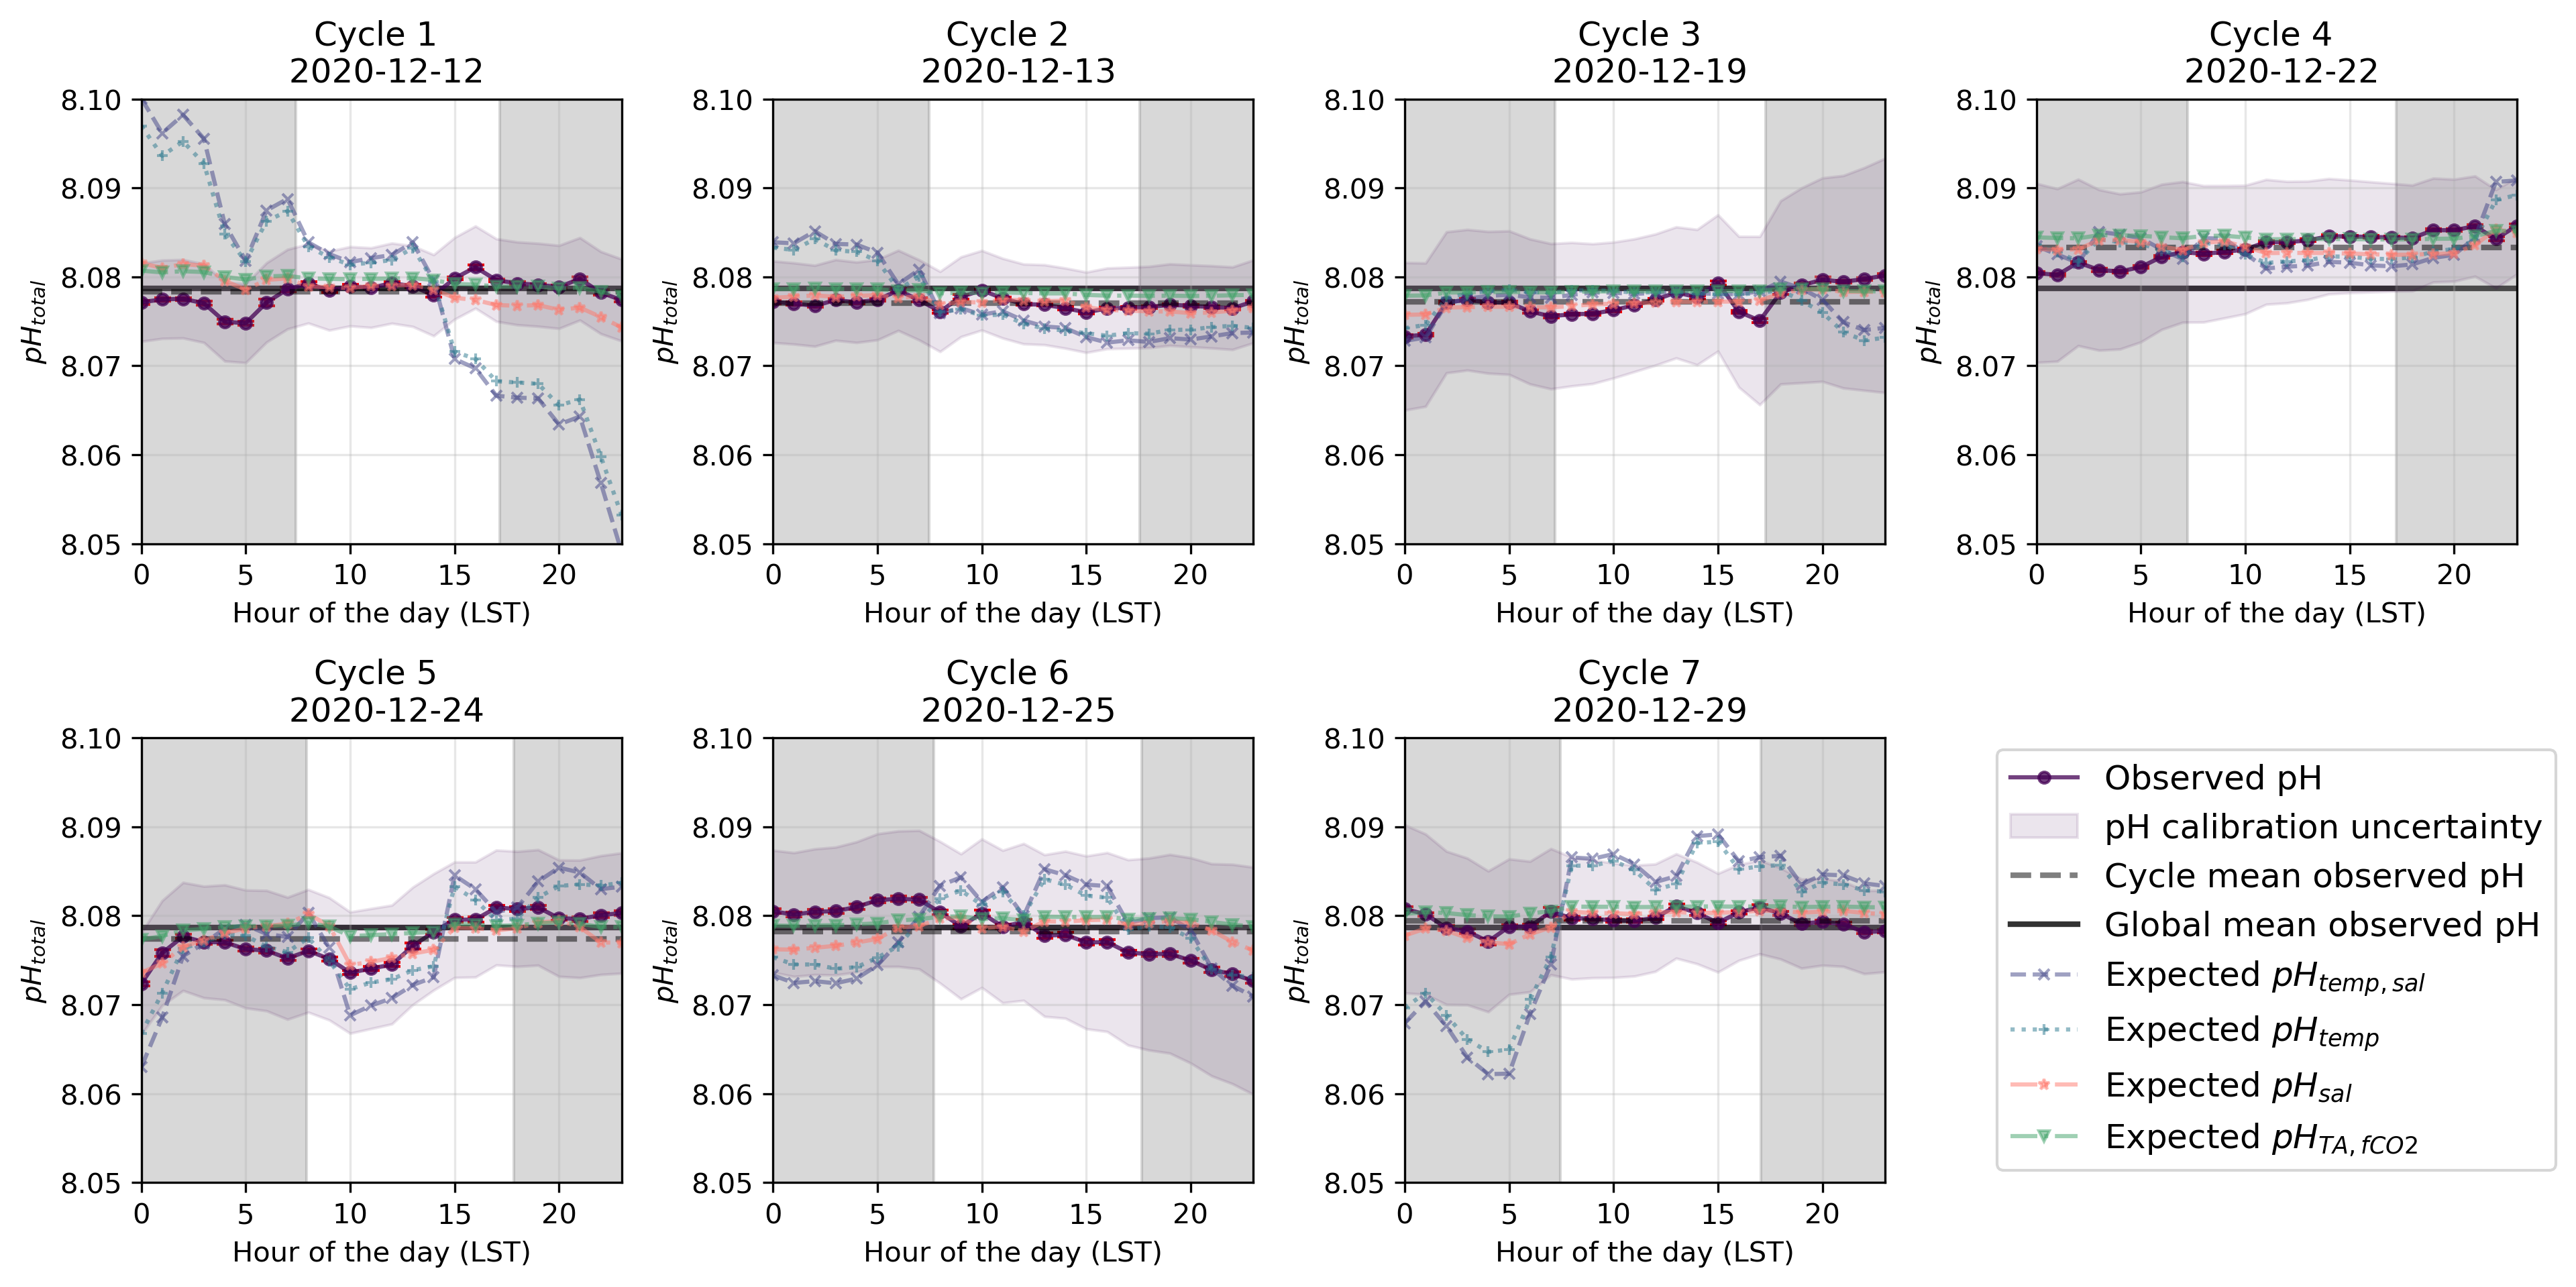

In [43]:
# Initialize figure and axes for plotting
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(13, 6.5), dpi=300)
axes_flat = axes.flatten()

def calculate_sunrise_sunset_lst(lat, lon, date_str):
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = date_str

    sunrise_utc = observer.next_rising(ephem.Sun(), start=ephem.Date(date_str)).datetime()
    sunset_utc = observer.next_setting(ephem.Sun(), start=ephem.Date(date_str)).datetime()

    def utc_to_lst(utc_datetime, longitude):
        offset = int(longitude / 15)
        return utc_datetime + timedelta(hours=offset)

    sunrise_lst = utc_to_lst(sunrise_utc, lon)
    sunset_lst = utc_to_lst(sunset_utc, lon)

    sunrise_hour = sunrise_lst.hour + sunrise_lst.minute / 60
    sunset_hour = sunset_lst.hour + sunset_lst.minute / 60

    return sunrise_hour, sunset_hour

def monte_carlo_simulation(df, iterations=1000):
    hourly_groups = df.groupby('Hour')
    pH_std_per_hour = {}

    for hour, group in hourly_groups:
        sampled_pH_values = []
        for _ in range(iterations):
            # Sample 50% of the data available for this hour
            sampled_df = group.sample(frac=0.5, replace=True)
            sampled_pH_values.append(sampled_df['pH_TS_measured (optode)'].mean())
        # Calculate the standard deviation of the sampled means for this hour
        pH_std_per_hour[hour] = np.std(sampled_pH_values)

    # Convert the dictionary to a DataFrame for easier handling in later plotting
    return pd.DataFrame.from_dict(pH_std_per_hour, orient='index', columns=['pH_std'])

def calculate_expected_pH_hourly(df):
    mean_TA = df['talk'].mean()
    mean_DIC = df['tco2'].mean()
    mean_fCO2 = df['fco2'].mean()
    mean_temperature = df['Temperature'].mean()
    mean_salinity = df['Salinity'].mean()

    uncertainty_from = pyco2.uncertainty_OEDG18.copy()
    uncertainty_from["par1"] = 5.5
    uncertainty_from["par2"] = df['tco2_unc'].mean()

    df['Hour'] = pd.to_datetime(df['datetime_lst']).dt.hour
    hourly_means = df.groupby('Hour').mean(numeric_only=True)

    pH_temp_sal = []
    pH_temp = []
    pH_sal = []
    pH_TA_DIC = []
    pH_TA_fco2 = []

    for _, row in hourly_means.iterrows():
        # pH_temp_sal
        temp_sal_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=row['Salinity'], temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0,
            uncertainty_from=uncertainty_from, uncertainty_into=['pH_total']
        )
        pH_temp_sal.append(temp_sal_result['pH_total'])

        # pH_temp
        temp_fluct_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=mean_salinity, temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0,
            uncertainty_from=uncertainty_from, uncertainty_into=['pH_total']
        )
        pH_temp.append(temp_fluct_result['pH_total'])

        # pH_sal
        sal_fluct_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=row['Salinity'], temperature=mean_temperature,
            pressure=3, total_silicate=0, total_phosphate=0,
            uncertainty_from=uncertainty_from, uncertainty_into=['pH_total']
        )
        pH_sal.append(sal_fluct_result['pH_total'])

        # pH_TA_DIC
        dic_ta_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=row['Salinity'], temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0
        )
        pH_TA_DIC.append(dic_ta_result['pH_total'])

        # pH_TA_fco2
        ta_fco2_result = pyco2.sys(
            par1=mean_TA, par2=mean_fCO2, par1_type=1, par2_type=4,
            salinity=row['Salinity'], temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0
        )
        pH_TA_fco2.append(ta_fco2_result['pH_total'])

    hourly_means['pH_temp_sal'] = pH_temp_sal
    hourly_means['pH_temp'] = pH_temp
    hourly_means['pH_sal'] = pH_sal
    hourly_means['pH_TA_DIC'] = pH_TA_DIC
    hourly_means['pH_TA_fco2'] = pH_TA_fco2

    return hourly_means

# Get the Viridis colormap
viridis = plt.cm.get_cmap('viridis', 6)

def plot_actual_vs_expected_pH_hourly(ax, hourly_means, cycle_num, mean_pH_per_cycle, SO279_global_mean_pH, latitude, longitude, date, pH_std_df):
    # Calculate sunrise and sunset hours in LST for shading
    sunrise_hour, sunset_hour = calculate_sunrise_sunset_lst(latitude, longitude, date.strftime('%Y/%m/%d'))

    # Night hours: from sunset to sunrise of the next day
    if sunset_hour > sunrise_hour:  # Sunset and sunrise occur on the same day
        ax.fill_betweenx([7, 9], 0, sunrise_hour, color='grey', alpha=0.3, zorder=1)
        ax.fill_betweenx([7, 9], sunset_hour, 24, color='grey', alpha=0.3, zorder=1)
    else:  # Sunset occurs before midnight and sunrise after midnight
        ax.fill_betweenx([7, 9], sunset_hour, sunrise_hour, color='grey', alpha=0.1, zorder=1)

    # Plot observed pH with uncertainty window
    pH_upper = hourly_means['pH_TS_measured (optode)'] + hourly_means['pH_TS_measured (optode) uncertainty']
    pH_lower = hourly_means['pH_TS_measured (optode)'] - hourly_means['pH_TS_measured (optode) uncertainty']
    ax.plot(hourly_means.index, hourly_means['pH_TS_measured (optode)'], label='Observed pH',  marker='o', linestyle='-', markersize=4, alpha=0.75, color=viridis(0))
    ax.fill_between(hourly_means.index, pH_lower, pH_upper, color=viridis(0), alpha=0.1, label='pH calibration uncertainty')

    # Add error bars using Monte Carlo standard deviations for each hour
    ax.errorbar(hourly_means.index, hourly_means['pH_TS_measured (optode)'], yerr=pH_std_df['pH_std'], fmt='none', ecolor='red', capsize=3, label='_nolegend_', zorder=0)

    # Add cycle mean
    ax.axhline(y=mean_pH_per_cycle, color='k', alpha=0.5, linestyle='dashed', linewidth=2, label='Cycle mean observed pH')

    # Add global mean across all cycles
    ax.axhline(y=SO279_global_mean_pH, color='k', alpha=0.8, linewidth=2, label='Global mean observed pH', zorder=0)

    # Plot expected pH from various calculations
    ax.plot(hourly_means.index, hourly_means['pH_temp_sal'], label='Expected $pH_{temp, sal}$', marker='x', linestyle='--', markersize=4, alpha=0.5, color=viridis(1))
    ax.plot(hourly_means.index, hourly_means['pH_temp'], label='Expected $pH_{temp}$', marker='+', linestyle=':', markersize=4, alpha=0.5, color=viridis(2))
    ax.plot(hourly_means.index, hourly_means['pH_sal'], label='Expected $pH_{sal}$', marker='*', linestyle='-.', markersize=4, alpha=0.5, color='xkcd:salmon')
    ax.plot(hourly_means.index, hourly_means['pH_TA_fco2'], label='Expected $pH_{TA, fCO2}$', marker='v', linestyle='-.', markersize=4, alpha=0.5, color="xkcd:greenish")

    ax.set_xlabel('Hour of the day (LST)')
    ax.set_ylabel('$pH_{total}$')
    ax.set_title(f"Cycle {cycle_num} \n {date.strftime('%Y-%m-%d')}")
    ax.grid(alpha=0.3)
    ax.set_xticks([0, 5, 10, 15, 20])

    ax.set_xlim(0, 23)
    ax.set_ylim(8.05, 8.1)

def process_cycle(df_cycle, ax, cycle_num, SO279_global_mean_pH):
    mean_latitude = df_cycle['Latitude'].mean()
    mean_longitude = df_cycle['Longitude'].mean()

    df_cycle['date'] = pd.to_datetime(df_cycle['datetime_lst']).dt.date
    unique_dates = df_cycle['date'].unique()
    mean_pH_per_cycle = df_cycle['pH_TS_measured (optode)'].mean()

    hourly_means = calculate_expected_pH_hourly(df_cycle)
    pH_std_df = monte_carlo_simulation(df_cycle)

    mean_pH_per_cycle = df_cycle['pH_TS_measured (optode)'].mean()

    if len(unique_dates) == 1:
        date = unique_dates[0]
        plot_actual_vs_expected_pH_hourly(ax, hourly_means, cycle_num, mean_pH_per_cycle, SO279_global_mean_pH, mean_latitude, mean_longitude, pd.to_datetime(date), pH_std_df)
        return hourly_means
    else:
        print("Cycle spans multiple dates; additional logic required.")
        return hourly_means  # fallback, may not be used

# --- MAIN LOOP: convert all cycles to hourly summary DataFrames with pH_* columns ---

north_atlantic_complete_cycles_hourly = []

for i, df_cycle in enumerate(north_atlantic_complete_cycles):
    ax = axes_flat[i]
    hourly_means = process_cycle(df_cycle, ax, i + 1, SO279_global_mean_pH)
    north_atlantic_complete_cycles_hourly.append(hourly_means)

# Remove axis labels and ticks for the last subplot, if necessary
axes_flat[-1].axis('off')

# Create a legend in the last subplot using any of the previous subplots to extract handles and labels
handles, labels = axes_flat[0].get_legend_handles_labels()
handles = [h for h, l in zip(handles, labels) if l != '_nolegend_']
labels = [l for l in labels if l != '_nolegend_']
axes_flat[-1].legend(handles, labels, loc='center', fontsize=12)

plt.tight_layout()
plt.savefig("figs/figure4", dpi=300, bbox_inches="tight", pad_inches=0.1)


## SO289 - South Pacific Region

In [44]:
# Calculate the global mean pH across all cycles
SO289_global_mean_pH = pd.concat(south_pacific_complete_cycles)['pH_TS_measured (optode)'].mean()

In [ ]:
# Initialize figure and axes for plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 10), dpi=300)
axes_flat = axes.flatten()

def calculate_sunrise_sunset_lst(lat, lon, date_str):
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = date_str
    
    sunrise_utc = observer.next_rising(ephem.Sun(), start=ephem.Date(date_str)).datetime()
    sunset_utc = observer.next_setting(ephem.Sun(), start=ephem.Date(date_str)).datetime()
    
    def utc_to_lst(utc_datetime, longitude):
        offset = int(longitude / 15)
        return utc_datetime + timedelta(hours=offset)
    
    sunrise_lst = utc_to_lst(sunrise_utc, lon)
    sunset_lst = utc_to_lst(sunset_utc, lon)
    
    sunrise_hour = sunrise_lst.hour + sunrise_lst.minute / 60
    sunset_hour = sunset_lst.hour + sunset_lst.minute / 60
    
    return sunrise_hour, sunset_hour

def monte_carlo_simulation(df, iterations=1):
    hourly_groups = df.groupby('Hour')
    pH_std_per_hour = {}

    for hour, group in hourly_groups:
        sampled_pH_values = []
        for _ in range(iterations):
            # Sample 50% of the data available for this hour
            sampled_df = group.sample(frac=0.5, replace=True)
            sampled_pH_values.append(sampled_df['pH_TS_measured (optode)'].mean())
        # Calculate the standard deviation of the sampled means for this hour
        pH_std_per_hour[hour] = np.std(sampled_pH_values)

    return pd.DataFrame.from_dict(pH_std_per_hour, orient='index', columns=['pH_std'])

def calculate_expected_pH_hourly(df):
    mean_TA = df['talk'].mean()
    mean_DIC = df['tco2'].mean()
    mean_fCO2 = df['fco2'].mean()
    mean_temperature = df['Temperature'].mean()
    mean_salinity = df['Salinity'].mean()

    uncertainty_from = pyco2.uncertainty_OEDG18.copy()
    uncertainty_from["par1"] = 5.5
    uncertainty_from["par2"] = df['tco2_unc'].mean()

    df['Hour'] = pd.to_datetime(df['datetime_lst']).dt.hour
    hourly_means = df.groupby('Hour').mean(numeric_only=True)

    pH_temp_sal = []
    pH_temp = []
    pH_sal = []
    pH_TA_DIC = []
    pH_TA_fco2 = []

    for _, row in hourly_means.iterrows():
        # pH_temp_sal
        temp_sal_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=row['Salinity'], temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0,
            uncertainty_from=uncertainty_from, uncertainty_into=['pH_total']
        )
        pH_temp_sal.append(temp_sal_result['pH_total'])

        # pH_temp
        temp_fluct_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=mean_salinity, temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0,
            uncertainty_from=uncertainty_from, uncertainty_into=['pH_total']
        )
        pH_temp.append(temp_fluct_result['pH_total'])

        # pH_sal
        sal_fluct_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=row['Salinity'], temperature=mean_temperature,
            pressure=3, total_silicate=0, total_phosphate=0,
            uncertainty_from=uncertainty_from, uncertainty_into=['pH_total']
        )
        pH_sal.append(sal_fluct_result['pH_total'])

        # pH_TA_DIC
        dic_ta_result = pyco2.sys(
            par1=mean_TA, par2=mean_DIC, par1_type=1, par2_type=2,
            salinity=row['Salinity'], temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0
        )
        pH_TA_DIC.append(dic_ta_result['pH_total'])

        # pH_TA_fco2
        ta_fco2_result = pyco2.sys(
            par1=mean_TA, par2=mean_fCO2, par1_type=1, par2_type=4,
            salinity=row['Salinity'], temperature=row['Temperature'],
            pressure=3, total_silicate=0, total_phosphate=0
        )
        pH_TA_fco2.append(ta_fco2_result['pH_total'])

    # Add columns to DataFrame
    hourly_means['pH_temp_sal'] = pH_temp_sal
    hourly_means['pH_temp'] = pH_temp
    hourly_means['pH_sal'] = pH_sal
    hourly_means['pH_TA_DIC'] = pH_TA_DIC
    hourly_means['pH_TA_fco2'] = pH_TA_fco2

    # Return all for convenient unpacking in the next cell
    return (hourly_means,
            hourly_means['pH_temp_sal'],
            hourly_means['pH_temp'],
            hourly_means['pH_sal'],
            hourly_means['pH_TA_DIC'],
            hourly_means['pH_TA_fco2'])

viridis = plt.cm.get_cmap('viridis', 6)

def plot_actual_vs_expected_pH_hourly(ax, hourly_means, cycle_num, mean_pH_per_cycle, SO289_global_mean_pH, latitude, longitude, date, pH_std_df):
    sunrise_hour, sunset_hour = calculate_sunrise_sunset_lst(latitude, longitude, date.strftime('%Y/%m/%d'))
    if sunset_hour > sunrise_hour:
        ax.fill_betweenx([7, 9], 0, sunrise_hour, color='grey', alpha=0.3, zorder=1)
        ax.fill_betweenx([7, 9], sunset_hour, 24, color='grey', alpha=0.3, zorder=1)
    else:
        ax.fill_betweenx([7, 9], sunset_hour, sunrise_hour, color='grey', alpha=0.1, zorder=1)
    pH_upper = hourly_means['pH_TS_measured (optode)'] + hourly_means['pH_TS_measured (optode) uncertainty']
    pH_lower = hourly_means['pH_TS_measured (optode)'] - hourly_means['pH_TS_measured (optode) uncertainty']
    ax.plot(hourly_means.index, hourly_means['pH_TS_measured (optode)'], label='Observed pH',  marker='o', linestyle='-', markersize=4, alpha=0.75, color=viridis(0))
    ax.fill_between(hourly_means.index, pH_lower, pH_upper, color=viridis(0), alpha=0.1, label='pH calibration uncertainty')
    ax.errorbar(hourly_means.index, hourly_means['pH_TS_measured (optode)'], yerr=pH_std_df['pH_std'], fmt='none', ecolor='red', capsize=3, label='_nolegend_', zorder=0)
    ax.axhline(y=mean_pH_per_cycle, color='k', alpha=0.5, linestyle='dashed', linewidth=2, label='Cycle mean observed pH')
    ax.axhline(y=SO289_global_mean_pH, color='k', alpha=0.8, linewidth=2, label='Global mean observed pH', zorder=0)
    ax.plot(hourly_means.index, hourly_means['pH_temp_sal'], label='Expected $pH_{temp, sal}$', marker='x', linestyle='--', markersize=4, alpha=0.6, color=viridis(1))
    ax.plot(hourly_means.index, hourly_means['pH_temp'], label='Expected $pH_{temp}$', marker='+', linestyle=':', markersize=4, alpha=0.6, color=viridis(2))
    ax.plot(hourly_means.index, hourly_means['pH_sal'], label='Expected $pH_{sal}$', marker='*', linestyle='-.', markersize=4, alpha=0.6, color='xkcd:salmon')
    ax.plot(hourly_means.index, hourly_means['pH_TA_fco2'], label='Expected $pH_{TA, fCO2}$', marker='v', linestyle='-.', markersize=4, alpha=0.6, color="xkcd:greenish")
    ax.set_xlabel('Hour of the day (LST)')
    ax.set_ylabel('$pH_{total}$')
    ax.set_title(f"Cycle {cycle_num} \n {date.strftime('%Y-%m-%d')}")
    ax.grid(alpha=0.3)
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_xlim(0, 23)
    ax.set_ylim(7.97, 8.05)

def process_cycle(df_cycle, ax, cycle_num, SO289_global_mean_pH):
    mean_latitude = df_cycle['Latitude'].mean()
    mean_longitude = df_cycle['Longitude'].mean()
    df_cycle['date'] = pd.to_datetime(df_cycle['datetime_lst']).dt.date
    unique_dates = df_cycle['date'].unique()
    mean_pH_per_cycle = df_cycle['pH_TS_measured (optode)'].mean()
    hourly_means, pH_temp_sal, pH_temp, pH_sal, pH_TA_DIC, pH_TA_fco2 = calculate_expected_pH_hourly(df_cycle)
    pH_std_df = monte_carlo_simulation(df_cycle)
    mean_pH_per_cycle = df_cycle['pH_TS_measured (optode)'].mean()
    if len(unique_dates) == 1:
        date = unique_dates[0]
        plot_actual_vs_expected_pH_hourly(ax, hourly_means, cycle_num, mean_pH_per_cycle, SO289_global_mean_pH, mean_latitude, mean_longitude, pd.to_datetime(date), pH_std_df)
    else:
        print("Cycle spans multiple dates; additional logic required.")
    # Return the expected pH columns so you can use them after
    return hourly_means, pH_temp_sal, pH_temp, pH_sal, pH_TA_DIC, pH_TA_fco2

# --- MAIN LOOP: returns all as lists for downstream use ---
south_pacific_complete_cycles_hourly = []
pH_temp_sal_all = []
pH_temp_all = []
pH_sal_all = []
pH_TA_DIC_all = []
pH_TA_fco2_all = []

for i, df_cycle in enumerate(south_pacific_complete_cycles):
    ax = axes_flat[i]
    (hourly_means,
     pH_temp_sal,
     pH_temp,
     pH_sal,
     pH_TA_DIC,
     pH_TA_fco2) = process_cycle(df_cycle, ax, i + 1, SO289_global_mean_pH)
    south_pacific_complete_cycles_hourly.append(hourly_means)
    pH_temp_sal_all.append(pH_temp_sal)
    pH_temp_all.append(pH_temp)
    pH_sal_all.append(pH_sal)
    pH_TA_DIC_all.append(pH_TA_DIC)
    pH_TA_fco2_all.append(pH_TA_fco2)

axes_flat[-1].axis('off')
handles, labels = axes_flat[0].get_legend_handles_labels()
handles = [h for h, l in zip(handles, labels) if l != '_nolegend_']
labels = [l for l in labels if l != '_nolegend_']
axes_flat[-1].legend(handles, labels, loc='center', fontsize=12)
plt.tight_layout()
plt.savefig("figs/figure5.png", dpi=300, bbox_inches="tight", pad_inches=0.1)


# 9 - Residuals for observed pH distribution with expected pH calculations

## SO279 - North Atlantic Region

In [ ]:
north_atlantic_complete_cycles_hourly[0].columns

In [ ]:
# Function to calculate residuals and print statistics
def calculate_residuals(df, cycle_num):
    df['residuals_temp_sal'] = df['pH_TS_measured (optode)'] - df['pH_temp_sal']
    df['residuals_temp'] = df['pH_TS_measured (optode)'] - df['pH_temp']
    df['residuals_sal'] = df['pH_TS_measured (optode)'] - df['pH_sal']
    df['residuals_TA_DIC'] = df['pH_TS_measured (optode)'] - df['pH_TA_DIC']
    df['residuals_TA_fCO2'] = df['pH_TS_measured (optode)'] - df['pH_TA_fco2']
    
    # Print min, max, and mean residuals for each column
    residuals_cols = ['residuals_temp_sal', 'residuals_temp', 'residuals_sal', 'residuals_TA_DIC', 'residuals_TA_fCO2']
    for col in residuals_cols:
        print(f"Cycle {cycle_num} - {col}: min={df[col].min()}, max={df[col].max()}, mean={df[col].mean()}")
    
    return df

# Apply the residuals calculation to each DataFrame in north_atlantic_complete_cycles
north_atlantic_residuals = [calculate_residuals(df.copy(), i+1) for i, df in enumerate(north_atlantic_complete_cycles_hourly)]

# Define markers and colors for each cycle
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H']
colors = plt.cm.viridis(np.linspace(0, 1, len(north_atlantic_residuals)))

# Function to plot residuals with different colors and markers for each DataFrame
def plot_residuals(ax, dfs, column, label, colors, markers):
    for i, df in enumerate(dfs):
        ax.plot(df.index, df[column], marker=markers[i % len(markers)], color=colors[i], alpha=0.7, linestyle='-', label=f'Cycle {i+1}')
    ax.set_xlabel('Hour of the day (LST)')
    ax.set_ylabel('Residuals')
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 23)
    ax.set_ylim(-0.03, 0.03)  # Set y-axis limits
    ax.axhline(0, color='black', linestyle='--')  # Add horizontal dashed line at y=0
    ax.text(0, 1.1, label, transform=ax.transAxes)

# Initialize figure and axes
fig, axes = plt.subplots(4, 1, figsize=(8, 10), dpi=300)

# Subplot labels
subplot_labels = ['a) $pH_{temp,sal}$', 'b) $pH_{temp}$', 'c) $pH_{sal}$', 'd) $pH_{TA, fCO_{2}}$']

# Subplot 1: Residuals for pH_temp_sal
plot_residuals(axes[0], north_atlantic_residuals, 'residuals_temp_sal', subplot_labels[0], colors, markers)

# Subplot 2: Residuals for pH_temp
plot_residuals(axes[1], north_atlantic_residuals, 'residuals_temp', subplot_labels[1], colors, markers)

# Subplot 3: Residuals for pH_sal
plot_residuals(axes[2], north_atlantic_residuals, 'residuals_sal', subplot_labels[2], colors, markers)

# Subplot 4: Residuals for pH_TA_fCO2
plot_residuals(axes[3], north_atlantic_residuals, 'residuals_TA_fCO2', subplot_labels[3], colors, markers)

# Create a single legend below the last subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(north_atlantic_residuals), bbox_to_anchor=(0.53, -0.06), frameon=False)

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig("figs/figure6.png", dpi=300, bbox_inches="tight", pad_inches=0.1)

plt.show()


## SO289 - South Pacific Ocean

In [ ]:
# Function to calculate residuals and print statistics
def calculate_residuals(df, cycle_num):
    df['residuals_temp_sal'] = df['pH_TS_measured (optode)'] - df['pH_temp_sal']
    df['residuals_temp'] = df['pH_TS_measured (optode)'] - df['pH_temp']
    df['residuals_sal'] = df['pH_TS_measured (optode)'] - df['pH_sal']
    df['residuals_TA_DIC'] = df['pH_TS_measured (optode)'] - df['pH_TA_DIC']
    df['residuals_TA_fCO2'] = df['pH_TS_measured (optode)'] - df['pH_TA_fco2']
    
    # Print min, max, and mean residuals for each column
    residuals_cols = ['residuals_temp_sal', 'residuals_temp', 'residuals_sal', 'residuals_TA_DIC', 'residuals_TA_fCO2']
    for col in residuals_cols:
        print(f"Cycle {cycle_num} - {col}: min={df[col].min()}, max={df[col].max()}, mean={df[col].mean()}")
    
    return df

# Apply the residuals calculation to each DataFrame in south_pacific_complete_cycles
south_pacific_residuals = [calculate_residuals(df.copy(), i+1) for i, df in enumerate(south_pacific_complete_cycles_hourly)]

# Define markers and colors for each cycle
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H']
colors = plt.cm.viridis(np.linspace(0, 1, len(south_pacific_residuals)))

# Function to plot residuals with different colors and markers for each DataFrame
def plot_residuals(ax, dfs, column, label, colors, markers):
    for i, df in enumerate(dfs):
        ax.plot(df.index, df[column], marker=markers[i % len(markers)], color=colors[i], alpha=0.7, linestyle='-', label=f'Cycle {i+1}')
    ax.set_xlabel('Hour of the day (LST)')
    ax.set_ylabel('Residuals')
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 23)
    ax.set_ylim(-0.03, 0.03)  # Set y-axis limits
    ax.axhline(0, color='black', linestyle='--')  # Add horizontal dashed line at y=0
    ax.text(0, 1.1, label, transform=ax.transAxes)

# Initialize figure and axes
fig, axes = plt.subplots(4, 1, figsize=(8, 10))

# Subplot labels
subplot_labels = ['a) $pH_{temp,sal}$', 'b) $pH_{temp}$', 'c) $pH_{sal}$', 'd) $pH_{TA, fCO_{2}}$']

# Subplot 1: Residuals for pH_temp_sal
plot_residuals(axes[0], south_pacific_residuals, 'residuals_temp_sal', subplot_labels[0], colors, markers)

# Subplot 2: Residuals for pH_temp
plot_residuals(axes[1], south_pacific_residuals, 'residuals_temp', subplot_labels[1], colors, markers)

# Subplot 3: Residuals for pH_sal
plot_residuals(axes[2], south_pacific_residuals, 'residuals_sal', subplot_labels[2], colors, markers)

# Subplot 4: Residuals for pH_TA_DIC
# plot_residuals(axes[3], south_pacific_residuals, 'residuals_TA_DIC', subplot_labels[3], colors, markers)

# Subplot 5: Residuals for pH_TA_fCO2
plot_residuals(axes[3], south_pacific_residuals, 'residuals_TA_fCO2', subplot_labels[3], colors, markers)

# Create a single legend below the last subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=(len(labels) + 1) // 2, bbox_to_anchor=(0.55, -0.06), frameon=False, columnspacing=1.0, handletextpad=0.5)

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig("figs/figure7.png", dpi=300, bbox_inches="tight", pad_inches=0.1)

plt.show()


## 10 - T/S diagram with pH

In [ ]:
# Function to plot salinity vs. temperature with pH as colorbar
def plot_sal_temp_with_pH(ax, df):
    # Drop NaN values
    df = df.dropna(subset=['Temperature', 'Salinity', 'pH_TS_measured (optode)'])
    
    # Scatter plot
    sc = ax.scatter(df['Salinity'], df['Temperature'], c=df['pH_TS_measured (optode)'], cmap='plasma', alpha=0.7, edgecolor='k')
    
    # Set labels and title
    ax.set_xlabel('Salinity')
    ax.set_ylabel('Temperature')
#     ax.set_title(title)
    ax.grid(alpha=0.3)
    
    return sc

# Combine all data from each cycle into a single DataFrame for each basin
north_atlantic_data = pd.concat(north_atlantic_complete_cycles, ignore_index=True)
south_pacific_data = pd.concat(south_pacific_complete_cycles, ignore_index=True)

# Initialize figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: North Atlantic
sc1 = plot_sal_temp_with_pH(axes[0], north_atlantic_data)
axes[0].text(0.01, 1.05, 'a) North Atlantic Region', transform=axes[0].transAxes, fontsize=12, verticalalignment='top')

# Subplot 2: South Pacific
sc2 = plot_sal_temp_with_pH(axes[1], south_pacific_data)
axes[1].text(0.01, 1.05,'b) South Pacific Region', transform=axes[1].transAxes, fontsize=12, verticalalignment='top')

# Add color bars
cbar1 = plt.colorbar(sc1, ax=axes[0], orientation='vertical')
cbar1.set_label('Observed pH')

cbar2 = plt.colorbar(sc2, ax=axes[1], orientation='vertical')
cbar2.set_label('Observed pH')

# Adjust layout and show plot
plt.tight_layout()

# Save the plot
plt.savefig(
    "figs/figure8.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()

# 10 - Sensitivity analysis for CO<sub>2</sub> fluxes

In [ ]:
# Function to compute CO2 flux in gC/m²/hr
def compute_co2_flux(df):
    wind_speed = df["wind_speed"].values
    temp_C = df["Temperature"].values
    salinity = df["Salinity"].values
    pCO2_sw = df["pco2"].values
    pres_hPa = df.get("air_pressure_hpa", 1013.25)

    # Convert seawater pCO₂ to fCO₂
#     fCO2_sw = pCO2_to_fCO2(pCO2_sw, temp_C, pres_hPa=pres_hPa)

    # Determine atmospheric pCO₂ and convert to fCO₂
    if 'datetime' in df.columns:
        if df["datetime"].min().year == 2020:
            pCO2_air = 414.23
        else:
            pCO2_air = np.mean([419.24, 418.76, 420.19])
    else:
        pCO2_air = 415

#     fCO2_air = pCO2_to_fCO2(np.full_like(temp_C, pCO2_air), temp_C, pres_hPa=pres_hPa)

    k_w_cmhr = pyseaflux.gas_transfer_velocity.k_Ho06(wind_speed, temp_C)

    CO2_flux_mol_m2_day = pyseaflux.flux_calculations.flux_bulk(
        temp_C, salinity, pCO2_sw, pCO2_air, pres_hPa, k_w_cmhr
    )

    CO2_flux_g_m2_hr = (CO2_flux_mol_m2_day * 12.01) / 24
    return CO2_flux_g_m2_hr

# Compute fluxes for each cycle
north_atlantic_fluxes = [compute_co2_flux(cycle) for cycle in north_atlantic_complete_cycles]
south_pacific_fluxes = [compute_co2_flux(cycle) for cycle in south_pacific_complete_cycles]

# Step 1: Mean hourly fluxes per cycle
na_mean_fluxes = [np.nanmean(flux) for flux in north_atlantic_fluxes]
sp_mean_fluxes = [np.nanmean(flux) for flux in south_pacific_fluxes]

# Step 2: Mean variable-based flux per cycle
def mean_var_co2_flux(cycles):
    mean_fluxes = []
    for cycle in cycles:
        mean_vars = {
            'wind_speed': cycle['wind_speed'].mean(),
            'Temperature': cycle['Temperature'].mean(),
            'Salinity': cycle['Salinity'].mean(),
            'pco2': cycle['pco2'].mean()
        }
        mean_vars['air_pressure_hpa'] = cycle.get('air_pressure_hpa', pd.Series(1013.25)).mean()
        flux = compute_co2_flux(pd.DataFrame([mean_vars]))[0]
        mean_fluxes.append(flux)
    return mean_fluxes

na_mean_var_fluxes = mean_var_co2_flux(north_atlantic_complete_cycles)
sp_mean_var_fluxes = mean_var_co2_flux(south_pacific_complete_cycles)

# Step 3: 12AM and 12PM fluxes per cycle
def extract_am_pm_fluxes(cycles):
    fluxes_12am = []
    fluxes_12pm = []
    for df in cycles:
        df['datetime_lst'] = pd.to_datetime(df['datetime_lst'])
        fluxes_12am.append(df[df['datetime_lst'].dt.hour == 0]['CO2_flux'].mean())
        fluxes_12pm.append(df[df['datetime_lst'].dt.hour == 12]['CO2_flux'].mean())
    return fluxes_12am, fluxes_12pm

na_flux_12AM, na_flux_12PM = extract_am_pm_fluxes(north_atlantic_complete_cycles)
sp_flux_12AM, sp_flux_12PM = extract_am_pm_fluxes(south_pacific_complete_cycles)

# Prepare plot data
def prepare_plot_data(mean_hourly_fluxes, mean_var_fluxes, flux_12AM, flux_12PM, cycles_range):
    cycles = list(range(1, cycles_range + 1))
    extended_cycles = cycles * 4  # Four categories
    all_fluxes = mean_hourly_fluxes + mean_var_fluxes + flux_12AM + flux_12PM
    labels = (['Mean Hourly Flux'] * len(mean_hourly_fluxes) +
              ['Flux from Mean Variables'] * len(mean_var_fluxes) +
              ['12 AM (LST) Flux'] * len(flux_12AM) +
              ['12 PM (LST) Flux'] * len(flux_12PM))
    return pd.DataFrame({
        'Cycle': extended_cycles,
        'Flux': all_fluxes,
        'Type': labels
    })

na_data = prepare_plot_data(na_mean_fluxes, na_mean_var_fluxes, na_flux_12AM, na_flux_12PM, len(na_mean_fluxes))
sp_data = prepare_plot_data(sp_mean_fluxes, sp_mean_var_fluxes, sp_flux_12AM, sp_flux_12PM, len(sp_mean_fluxes))

In [ ]:
def plot_combined_cycle_fluxes(na_data, sp_data, titles, filename):
    fig, axes = plt.subplots(nrows=2, ncols=1, dpi=300, figsize=(7, 9)) 

    def create_plot(data, ax, title, label, y_lim=None):
        sns.barplot(x='Cycle', y='Flux', hue='Type', data=data, errorbar=('ci', 95), palette='magma', alpha=0.6, ax=ax)
        ax.axhline(0, color='black', linewidth=1, alpha=0.8)
        ax.set_xlabel('Diurnal Cycle')
        ax.set_ylabel("$\mathrm{CO_2}$ flux ($\mathrm{gC/m^2/hr}$)")
        ax.grid(alpha=0.3)
        ax.legend(loc='best')
        ax.text(0.15, 1.1, label, transform=ax.transAxes, fontsize=10, va='top', ha='right')
        if y_lim:
            ax.set_ylim(y_lim)
        if ax != axes[0]:  # Check if the current axis is not the first one
            ax.legend().remove()

    create_plot(na_data, axes[0], titles[0], 'a) North Atlantic Region')
    create_plot(sp_data, axes[1], titles[1], 'b) South Pacific Region')
    plt.tight_layout()
    plt.savefig(f"figs/sensitivity_fluxes.png", dpi=300)
    plt.show()

plot_combined_cycle_fluxes(na_data, sp_data, ["SO279 - North Atlantic Ocean Region", "SO289 - South Pacific Ocean Region"], "combined_ocean_fluxes")
